# Causal Inference Example

Estimate the causal effect of `a` on `y` in a business analysis scenario using Standardization and IP weighting.

References

- Hernán MA, Robins JM (2020). Causal Inference: What If. Boca Raton: Chapman & Hall/CRC.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn.linear_model as lm
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid",{"font.sans-serif":['microsoft yahei']})

import warnings
warnings.filterwarnings('ignore')

### Visualize Confounding

- prefix `c` stands for categorical
- prefix `n` stands for numerical
- `y` is the result
- `a` is the candidate of cause for `y`

In [2]:
# read sample data
df_ret = pd.read_csv('dataset_sample_retention.csv')

df_ret.head()

,y,a,c02,c03,c04,c05,c06,c07,n01,n02,n03,n04
0,0,1,1,0,0,0,0,0,0,0,0,0
1,1,1,2,2,0,1,1,1,2,0,26,542
2,1,0,2,0,0,0,1,0,1,0,74,0
3,0,0,0,2,0,0,1,0,0,0,8,0
4,1,1,1,2,0,0,1,1,3,120,90,0


In [3]:
def agg_conversion(df):
    return pd.Series({'users': df.shape[0],
                      'conversion': df['y'].mean()})

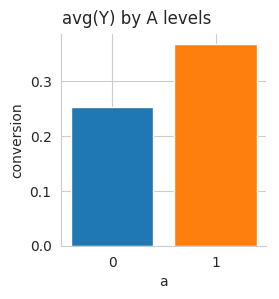

In [4]:
df_a = df_ret.assign(a=lambda x:x['a'].astype(str)).\
    groupby('a').\
    apply(agg_conversion).\
    reset_index()

g_a = sns.FacetGrid(data=df_a, hue='a')
g_a.map(plt.bar, 'a','conversion')

plt.subplots_adjust(top=0.9)
g_a.fig.suptitle('avg(Y) by A levels')
g_a.fig.set_dpi(100)

In [5]:
df_a

,a,users,conversion
0,0,40484.0,0.253038
1,1,9746.0,0.367535


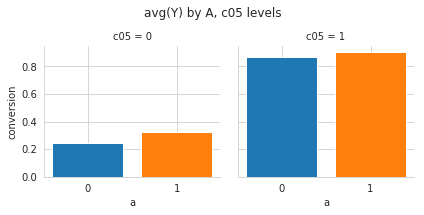

In [6]:
df_a_c05 = df_ret.assign(
    a=lambda x:x['a'].astype(str)).\
    groupby(['a','c05']).\
    apply(agg_conversion).\
    reset_index()

g_a_c05 = sns.FacetGrid(data=df_a_c05, hue='a', col='c05')
g_a_c05.map(plt.bar, 'a','conversion')

plt.subplots_adjust(top=0.8)
g_a_c05.fig.suptitle('avg(Y) by A, c05 levels')
g_a.fig.set_dpi(100)

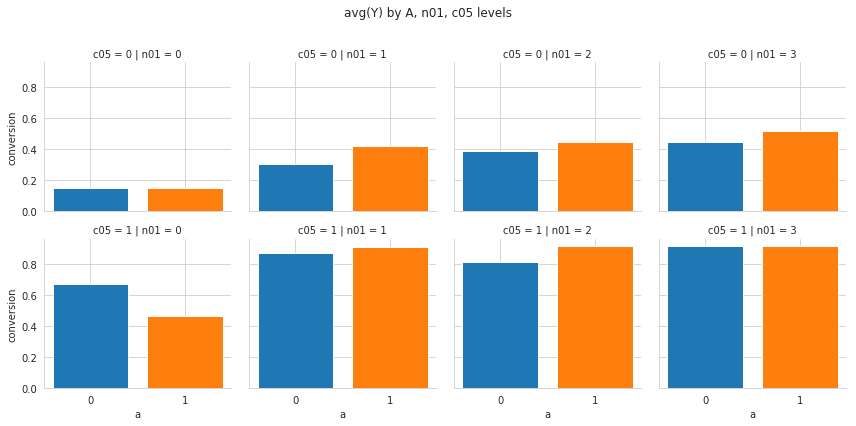

In [7]:
df_a_n01_c05 = df_ret.assign(a=lambda x:x['a'].astype(str)).\
    groupby(['a','n01','c05']).\
    apply(agg_conversion).\
    reset_index()

g_a_n01_c05 = sns.FacetGrid(data=df_a_n01_c05, 
    hue='a', col='n01', row='c05')
g_a_n01_c05.map(plt.bar, 'a','conversion')

plt.subplots_adjust(top=0.85)
g_a_n01_c05.fig.suptitle('avg(Y) by A, n01, c05 levels')
g_a.fig.set_dpi(100)

### Standardizing

#### non-parametric

Try adjust for 1 confounder `c05`.

In [8]:
# conditional exchangeablility on c05
df_a_c05_pivot = df_a_c05.\
    pivot_table(index='c05', columns='a', values=['users','conversion']).\
    assign(conversion_diff=lambda x: 
               x['conversion']['1']-x['conversion']['0'],
           group_users=lambda x: x['users'].sum(axis=1))

df_a_c05_pivot

conversion              users         conversion_diff group_users
a            0         1        0       1                            
c05                                                                  
0     0.241449  0.321524  39731.0  8976.0        0.080075     48707.0
1     0.864542  0.903896    753.0   770.0        0.039354      1523.0

In [9]:
sum(df_a_c05_pivot['conversion_diff']*df_a_c05_pivot['group_users'])/sum(df_a_c05_pivot['group_users'])

0.07884063773304156

#### parametric

Adjust for multiple confounders.

In [10]:
# add columns for later use
df_ret['one'] = 1
df_ret['zero'] = 0

# add squared terms for continuous features
for col in ['n01','n02','n03','n04']:
    df_ret[f"{col}^2"] = df_ret[col]**2
    
# normalize numerical columns for regularization
n_std = StandardScaler().fit_transform(df_ret.filter(regex='^n'))
df_ret[df_ret.filter(regex='^n').columns.tolist()] = n_std
    
# add dummies for categorical features
for col in ['c02','c03','c04','c05','c06','c07']:
    if len(df_ret[col].unique()) >= 3:
        print(f'getting dummies for {col}')
        df_ret = pd.concat([df_ret,
            pd.get_dummies(df_ret[col], prefix=col)],axis=1)

getting dummies for c02
getting dummies for c03


In [11]:
# select features: a, continuous and their squared, dummies
common_X = [
    'c04', 'c05', 'c06', 'c07', 'n01', 'n02', 
    'n03', 'n04', 'one', 'n01^2', 'n02^2', 'n03^2', 
    'n04^2', 'c02_0', 'c02_1', 'c02_2', 'c02_3', 
    'c02_4', 'c02_5', 'c03_0', 'c03_1', 'c03_2'
]
# features and target
X = df_ret[['a'] + common_X]
y = df_ret['y'].tolist()

# suppose a=1 & a=0 for all samples
X_all_treated = df_ret[['one'] + common_X]
X_all_untreated = df_ret[['zero'] + common_X]

In [12]:
# fit classifier
# mod = lm.LogisticRegression(
#     fit_intercept=False,
#     C=5
# )
mod = lgb.LGBMClassifier()

mod.fit(X, y)

# predict
pred_all_treated = mod.predict_proba(X_all_treated)[:,1]
pred_all_untreated = mod.predict_proba(X_all_untreated)[:,1]

In [13]:
# estimate causal effect
mean_all_t = pred_all_treated.mean()
mean_all_u = pred_all_untreated.mean()
est_diff = mean_all_t - mean_all_u

print(f'  mean_all_treated prediction: {mean_all_t:>0.4f}')
print(f'mean_all_untreated prediction: {mean_all_u:>0.4f}')
print(f'       causal effect estimate: {est_diff:>0.4f}')

  mean_all_treated prediction: 0.3027
mean_all_untreated prediction: 0.2690
       causal effect estimate: 0.0337


In [14]:
# boostrap for the confidence interval
# NOTE: this might take a few minutes!!!
boot_samples = []

for _ in range(100):
    sample = df_ret.sample(
        n=df_ret.shape[0], 
        replace=True
    )
    X = sample[['a'] + common_X]
    y = df_ret['y'].tolist()
    X_t = sample[['one'] + common_X]
    X_u = sample[['zero'] + common_X]
    
    try:
        mod = lgb.LGBMClassifier(
            objective = 'binary')
        mod.fit(X, y)
        pred_t = mod.predict_proba(X_t)[:,1]
        pred_u = mod.predict_proba(X_u)[:,1]
        boot_samples.append(pred_t.mean() - pred_u.mean())
    except:
        continue

In [15]:
std = np.std(boot_samples)
lo = est_diff - 1.96 * std
hi = est_diff + 1.96 * std
print(f'causal effect: {est_diff:>0.4f}')
print(f'95% C.I.: ({lo:>0.4f}, {hi:>0.4f})')

causal effect: 0.0337
95% C.I.: (0.0248, 0.0426)


### IP weighting

#### parametrics

Get standardized inverse probability weights $SW^A = \frac{f(A)}{f(A|L)}$.

In [16]:
# for ip weights

# def logit_ip(y, X):
#     model = sm.Logit(y, X)
#     res = model.fit()
#     weights = np.zeros(X.shape[0])
#     weights[y == 1] = res.predict(X.loc[y == 1])
#     weights[y == 0] = (1 - res.predict(X.loc[y == 0]))
#     return weights


def logit_ip(y, X):
    mod = lm.LogisticRegression(
        fit_intercept=False,
        C=5
    )
    mod.fit(X, y)
    weights = np.zeros(X.shape[0])
    weights[y == 1] = \
        mod.predict_proba(X.loc[y == 1])[:,1]
    weights[y == 0] = \
        mod.predict_proba(X.loc[y == 0])[:,0]
    return weights

def gbm_ip(y, X):
    mod = lgb.LGBMClassifier()
    mod.fit(X, y)
    weights = np.zeros(X.shape[0])
    weights[y == 1] = \
        mod.predict_proba(X.loc[y == 1])[:,1]
    weights[y == 0] = \
        mod.predict_proba(X.loc[y == 0])[:,0]
    return weights

In [17]:
# standardized weights
denoms = logit_ip(
    df_ret['a'], 
    df_ret[common_X]
)
weights = 1 / denoms

treat = (df_ret['a']==1)
s_weights = np.zeros(df_ret.shape[0])
s_weights[treat] = \
    treat.mean() * weights[treat]
s_weights[~treat] = \
    (1 - treat).mean() * weights[~treat]

Fit linear regression formula `Y ~ 1 + A` with standardized weights for all samples.

In [18]:
# fit gee model
gee = sm.GEE(
    df_ret['y'],
    df_ret[['one', 'a']],
    groups=df_ret.index.tolist(),
    weights=s_weights
)

gee.fit().summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
one,0.2696,0.002,115.943,0.000,0.265,0.274
a,0.0349,0.005,6.391,0.000,0.024,0.046


### Regression with Propensity Score

Fit linear regression formula `Y ~ 1 + A + Pi`

In [19]:
# using denoms in previous results
df_ret['propensity'] = denoms

gee = sm.GEE(
    df_ret['y'],
    df_ret[['one','a','propensity']],
    groups=df_ret.index.tolist()
)

gee.fit().summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
one,0.4032,0.020,20.206,0.000,0.364,0.442
a,0.0103,0.015,0.669,0.503,-0.020,0.041
propensity,-0.1832,0.024,-7.673,0.000,-0.230,-0.136


### learning

关于 causal inference

- 模型中尽量加入更多的变量 (原书用 `L` 表示), 作为 confounders 备选
- 对移动产品, 如果要判断某个功能或行为对一个指标的作用, 变量要包含用户使用该功能的先决条件
- 使用同一组变量, Standardization 和 IP weighting 的结果可能有显著差异
- 其中的多数分类模型, 可以用非参模型 (如: gradient boosting) 替代

通用知识

- 包含正则项的预测模型, X 变量尽量做标准化